In [54]:
import requests
import pandas as pd
import io
import numpy as np

# Define the SPARQL endpoint
endpoint = "https://www.govdata.de/sparql"

# Get the proxy URL
proxy_url = requests.utils.getproxies().get('http')

# Set the proxy configuration
proxies = {'http': proxy_url}



query = """
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX dcatde: <http://dcat-ap.de/def/dcatde/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?dataset ?title ?publisher_name ?distribution_link ?publication_year
WHERE {
  ?dataset a dcat:Dataset ;
            dct:title ?title ;
            dcat:distribution ?distribution ;
            dct:publisher ?publisher .
  OPTIONAL {?publisher foaf:name ?publisher_name} .
  FILTER(REGEX(lcase(?publisher_name),'^bm.*|bundesminist.*|^ausw.*|^aa$')) .
  OPTIONAL { ?distribution dcat:accessURL ?distribution_link } .
  OPTIONAL { ?dataset dct:issued ?publication_date } .
  BIND (year(?publication_date) as ?publication_year)
}
"""

# Send the SPARQL query and get the response in CSV format
url = endpoint + '?query=' + requests.utils.quote(query, safe='')
headers = {'Accept': 'text/csv'}
response = requests.get(url, headers=headers, proxies=proxies, timeout=60)

# Convert the CSV response to a Pandas DataFrame
df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))

# Delete unnecessary variables
del endpoint, proxy_url, proxies, query, url, headers, response


In [55]:
# Use np.select to create a new column publisher_short with the short publisher name
conditions = [
    df['publisher_name'].str.contains('Wirtschaft und|BMWK|BMWI', case=False),
    df['publisher_name'].str.contains('Finanzen|^BMF', case=False),
    df['publisher_name'].str.contains('Innern|^BMI', case=False),
    df['publisher_name'].str.contains('^Ausw|^AA', case=False),
    df['publisher_name'].str.contains('Justitz|BMJ', case=False),
    df['publisher_name'].str.contains('Arbeit|BMAS', case=False),
    df['publisher_name'].str.contains('Verteidigung|BMVg', case=False),
    df['publisher_name'].str.contains('Landwirtschaft|BMEL', case=False),
    df['publisher_name'].str.contains('Familie|BMFSFJ', case=False),
    df['publisher_name'].str.contains('Gesundheit|BMG', case=False),
    df['publisher_name'].str.contains('Verkehr|BMDV', case=False),
    df['publisher_name'].str.contains('Umwelt|BMUV', case=False),
    df['publisher_name'].str.contains('Bildung|BMBF', case=False),
    df['publisher_name'].str.contains('Entwicklung|BMZ', case=False),
    df['publisher_name'].str.contains('Wohnen|BMWSB', case=False),
    df['publisher_name'].str.contains('Bundeskanzleramt|BKAmt', case=False)
]

choices = ['BMWK', 'BMF', 'BMI', 'AA', 'BMJ', 'BMAS', 'BMVg', 'BMEL', 'BMFSFJ', 'BMG', 'BMDV', 'BMUV', 'BMBF', 'BMZ', 'BMWSB', 'BKAmt']
df['publisher_short'] = np.select(conditions, choices, default='other')

# Create factor column for the publisher_short column
df['publisher_short'] = pd.Categorical(df['publisher_short'], categories=choices, ordered=True)

# Delete variables that are not needed anymore
del choices, conditions

In [57]:
# Subset the file format from the distribution_link column
df['file_format'] = df['distribution_link'].str.split('.').str[-1]

# Export df to CSV
df.to_csv('output/govdata.csv', index=False)

In [62]:
# Count number of file formats
df_file_format = df['file_format'].value_counts()


In [47]:
# Get only distinct datasets
df_distinct = df.drop_duplicates(subset=['dataset'])

In [48]:
# Count the number of datasets per publisher
df_distinct_publ = df_distinct['publisher_short'].value_counts()
print(df_distinct_publ)

BMBF      387
BMDV      278
BMAS       63
BMFSFJ     60
BMF        54
BMI        25
BMWK       20
BMZ        11
AA          8
BMEL        6
BMVg        4
BMG         3
BMJ         0
BMUV        0
BMWSB       0
BKAmt       0
Name: publisher_short, dtype: int64


In [49]:
random_rows = df.sample(n=10)

In [53]:
import requests

# List of URLs to check
urls = random_rows.distribution_link
# Create a list of dictionaries to store the results
results = []

# Check the status of each URL and store the result in the list of dictionaries
for url in urls:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            status = "OK"
        else:
            status = f"Error {response.status_code}"
    except requests.exceptions.RequestException as e:
        status = f"Error {e}"
    results.append({"url": url, "status": status})

# Create a DataFrame from the list of dictionaries
results_url_status = pd.DataFrame(results)

# Save the DataFrame to a CSV file
results_url_status.to_csv("output/results_url_status.csv", index=False)

# Print the DataFrame
print(results_url_status)

# Delete variables that are not needed anymore
del results, random_rows, response, url, urls

                                                 url     status
0  https://www.bmi.bund.de/SharedDocs/downloads/D...  Error 403
1  https://www.datenportal.bmbf.de/portal/Tabelle...         OK
2  https://cdc.dwd.de/sdi/pid/OBS_DEU_P1D_T5CM_N/...         OK
3  https://www.datenportal.bmbf.de/portal/Tabelle...         OK
4  https://www.bmi.bund.de/DE/themen/moderne-verw...  Error 403
5                     https://www.breitbandatlas.de/         OK
6  https://www.dwd.de/DWD/warnungen/cap-feed/de/r...         OK
7  http://www.bundespolizei.de/DE/Service/Downloa...  Error 403
8  https://www.datenportal.bmbf.de/portal/Tabelle...         OK
9  https://www.datenportal.bmbf.de/portal/Tabelle...         OK


In [52]:
(results_url_status["status"] == "OK").sum()

7

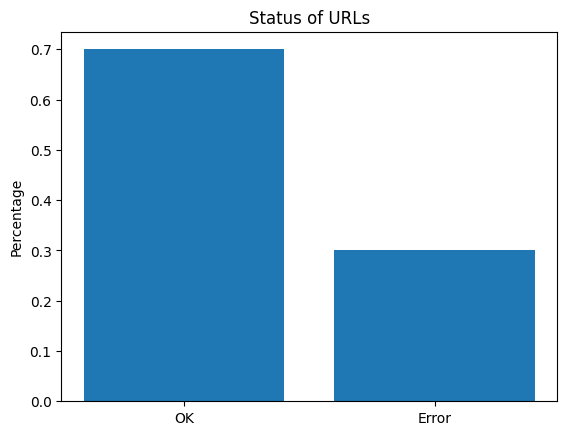

In [51]:
import matplotlib.pyplot as plt

# Replace all non-"OK" cells in the "status" column with "Error"
results_url_status.loc[results_url_status["status"] != "OK", "status"] = "Error"

# Group the DataFrame by status and count the number of URLs with each status
grouped = results_url_status.groupby("status").size()

# Calculate the percentage of "OK" and "Error" values
ok_percent = (results_url_status["status"] == "OK").sum() / len(results_url_status)
error_percent = (results_url_status["status"] == "Error").sum() / len(results_url_status)

# Plot the percentages as a bar chart
plt.bar(["OK", "Error"], [ok_percent, error_percent])
plt.ylabel("Percentage")
plt.title("Status of URLs")
plt.show()